In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import layers, models
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.layers import Conv2D, BatchNormalization, Add, AveragePooling2D
from tensorflow.keras.layers import ReLU, Flatten, Dense,Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import files
import os

In [ ]:
!git clone https://github.com/emresahinn19/HandPD-NewHandPD-Dataset
!pip install split-folders


Cloning into 'HandPD-NewHandPD-Dataset'...
remote: Enumerating objects: 901, done.
remote: Total 901 (delta 0), reused 0 (delta 0), pack-reused 901
Receiving objects: 100% (901/901), 183.71 MiB | 32.52 MiB/s, done.
Resolving deltas: 100% (20/20), done.
Updating files: 100% (1614/1614), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders


input_folder = "/content/dataset2"
output = "/content/handpd4"

splitfolders.ratio(input_folder, output, seed=123, ratio=(0.9,0,0.1)) #burası gerekli degil

Copying files: 253 files [00:01, 176.81 files/s]


In [ ]:
train_datagen = ImageDataGenerator(
                                  preprocessing_function=keras.applications.resnet.preprocess_input,
                                   validation_split=0.15





                                   #resnet50'nin preprocess_input fonksiyonunu kullanmak burada kilit nokta.
                                  )

test_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet.preprocess_input)



train_generator = train_datagen.flow_from_directory(
    '/content/handpd4/train',
    target_size=(224, 224),
    batch_size=64,
    shuffle=True,
    seed=123,
    subset='training',
    class_mode='binary')



val_generator = train_datagen.flow_from_directory(
    '/content/handpd4/train',
    target_size=(224, 224),
    batch_size=64,
    shuffle=True,
    seed=123,
    subset='validation',
    class_mode='binary')


test_generator = test_datagen.flow_from_directory(
                '/content/handpd4/test',
                target_size=(224,224),
                batch_size=64,
                shuffle=True,
                seed=123,

                class_mode='binary'
                )



Found 194 images belonging to 2 classes.
Found 33 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


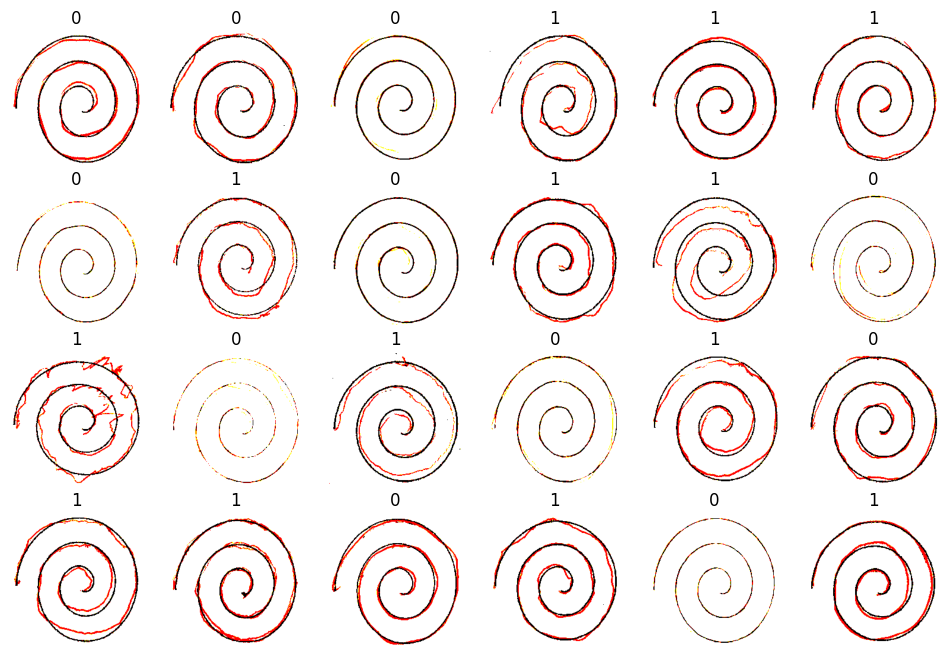

In [ ]:
augmented_image,label = train_generator.next()

plt.figure(figsize=(12,8))
for i in range(24):
        ax = plt.subplot(4, 6, i + 1)
        plt.imshow(augmented_image[i])
        plt.title(int(label[i]))
        plt.axis("off")
im = np.array(augmented_image[1]) # pre-trained resnet modeli, inputlari 0-1 arasina scale etmiyor.


In [ ]:




base_model = keras.applications.ResNet50(
    weights='imagenet',
     input_shape=(224, 224, 3),
     include_top=False)

base_model.trainable = True

inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
outputs = Dense( units = 1024, activation  = 'relu')(x)
x = keras.layers.Dropout(0.25)(x)
outputs = Dense( units = 1024, activation  = 'relu')(x)
x = keras.layers.Dropout(0.25)(x)
outputs = Dense( units = 1, activation  = 'sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_14 (Dropout)        (None, 2048)              0         
                                                                 
 dropout_15 (Dropout)        (None, 2048)              0         
                                                                 
 dense_23 (Dense)            (None, 1)                 2049      
                                                           

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=3e-6),
    loss='binary_crossentropy', #binary yap
    metrics=['accuracy',tf.keras.metrics.TruePositives(thresholds=0.5),
             tf.keras.metrics.TrueNegatives(thresholds=0.5),
             tf.keras.metrics.FalseNegatives(thresholds=0.5),
             tf.keras.metrics.FalsePositives(thresholds=0.5)]
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

callbacks = [early_stopping]
history = model.fit(
    train_generator,
    shuffle = True,
    validation_data= val_generator,
    batch_size=64,
    callbacks = callbacks,
    epochs=5,
    verbose = 1
)

Epoch 1/20
4/4 [==============================] - 47s 2s/step - loss: 0.2569 - accuracy: 0.8814 - true_positives_18: 87.0000 - true_negatives_18: 84.0000 - false_negatives_18: 8.0000 - false_positives_18: 15.0000 - val_loss: 0.1754 - val_accuracy: 0.9394 - val_true_positives_18: 15.0000 - val_true_negatives_18: 16.0000 - val_false_negatives_18: 1.0000 - val_false_positives_18: 1.0000
Epoch 2/20
4/4 [==============================] - 5s 1s/step - loss: 0.3079 - accuracy: 0.8711 - true_positives_18: 83.0000 - true_negatives_18: 86.0000 - false_negatives_18: 12.0000 - false_positives_18: 13.0000 - val_loss: 0.1817 - val_accuracy: 0.9394 - val_true_positives_18: 15.0000 - val_true_negatives_18: 16.0000 - val_false_negatives_18: 1.0000 - val_false_positives_18: 1.0000
Epoch 3/20
4/4 [==============================] - 6s 1s/step - loss: 0.2133 - accuracy: 0.9072 - true_positives_18: 85.0000 - true_negatives_18: 91.0000 - false_negatives_18: 10.0000 - false_positives_18: 8.0000 - val_loss: 0.

In [ ]:
result = model.evaluate( test_generator,
               verbose=1

              )



2/2 [==============================] - 2s 354ms/step - loss: 0.1254 - accuracy: 0.9783 - true_positives_13: 46.0000 - true_negatives_13: 44.0000 - false_negatives_13: 0.0000e+00 - false_positives_13: 2.0000


In [ ]:
tes = model.predict(test_generator, verbose=0)


In [ ]:
model.save('model1.h5')

<ipython-input-52-94c720089d88>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,accuracy,'b',color = 'red',label='Training Acc')
<ipython-input-52-94c720089d88>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs,loss,'b',color = 'red',label='Training Loss ')


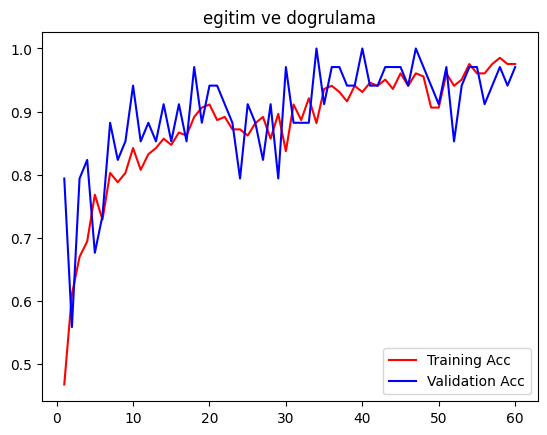

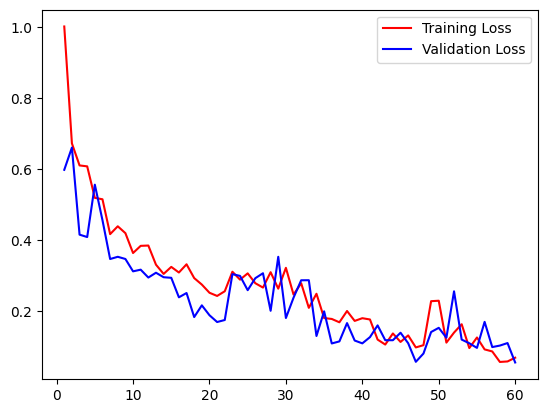

<Figure size 640x480 with 0 Axes>

In [ ]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(accuracy)+1)
plt.plot(epochs,accuracy,'b',color = 'red',label='Training Acc')
plt.plot(epochs,val_acc,'b',label='Validation Acc')
plt.title('Training and Validation Acc')
plt.legend()
plt.figure()
#
plt.plot(epochs,loss,'b',color = 'red',label='Training Loss ')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()

plt.show()